In [1]:
import numpy as np
import matplotlib
import pandas as pd
import time
import calendar
import datetime as dt
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import sys
from pandas import DataFrame
import matplotlib.pyplot as plt
import pyodbc

In [ ]:
connecting_string = '''
Driver={SQL Server Native Client 11.0};
Server=xxxxx\xxxxx;
Database=;
Uid=xxxxx\xxxxx;
Pwd=;
Trusted_Domain=;
Trusted_Connection=yes;
MARS_Connection=yes'''

connection = pyodbc.connect(connecting_string)

start = time.time()

failue_data='''

;WITH SummaryFile AS
(select K.InvestmentId,K.EffectiveDate, convert(float,substring(K.DataDetail_2,1,charindex(';',K.DataDetail_2)-1) ) as  TNA, min(K.ActionTime) as FailureGeneratedTime
from
(select InvestmentId, EffectiveDate, ActionTime, DataDetail, SUBSTRING(DataDetail,charindex(';TNA:',DataDetail)+5,len(DataDetail)-charindex(';TNA:',DataDetail))  as  DataDetail_2
from LogData_GPMainDB.dbo.PerformanceFailureDataSourceTracking
where DataUnit = 701
--and EffectiveDate > '2019-11-01'
--and ActionTime >= '2019-11-01'
--and ActionTime < '2019-11-05'
and ValidationCodeId !=0
--and InvestmentId = '0P0001GYBH'
)K
group by K.InvestmentId,K.EffectiveDate,convert(float,substring(K.DataDetail_2,1,charindex(';',K.DataDetail_2)-1) )
)


--aaa.ActionTime>DATEADD(HOUR,1,RawFileDate
--and DATEDIFF(DAY,aaa.EffectiveDate, bbb.RawFileDate) <=7
select J.InvestmentId, J.EffectiveDate, J.ValidationCodeId, J.ActionType_Real, J.ActionTime_Real, CONVERT(varchar,ActionTime_Real,23) as Date, 
CONVERT(varchar,ActionTime_Real,24) as Hour, J.TNA, J.FailureGeneratedTime,
case 
when (J.ActionType_Real !=1 and J.ActionTime_Real>DATEADD(HOUR,1,J.FailureGeneratedTime)) then 0  
when (J.ActionType_Real !=1 and J.ActionTime_Real<=DATEADD(HOUR,1,J.FailureGeneratedTime)) then 1
else 0 end   as  ActionStatus_OneHour,
case
when (J.ActionType_Real !=1 and J.ActionTime_Real>DATEADD(HOUR,24,J.FailureGeneratedTime)) then 0  
when (J.ActionType_Real !=1 and J.ActionTime_Real<=DATEADD(HOUR,24,J.FailureGeneratedTime)) then 1  
else 0 end   as  ActionStatus_24Hour,
case
when (J.ActionType_Real !=1 and J.ActionTime_Real>DATEADD(HOUR,1,J.FailureGeneratedTime)) then 0  
when (J.ActionType_Real !=1 and J.ActionTime_Real<=DATEADD(HOUR,1,J.FailureGeneratedTime)) then 1  
else 0 end   as  Complete_OneHour,
case
when (J.ActionType_Real !=1 and J.ActionTime_Real>DATEADD(day,1,J.FailureGeneratedTime)) then 0  
when (J.ActionType_Real !=1 and J.ActionTime_Real<=DATEADD(day,1,J.FailureGeneratedTime)) then 1  
else 0 end   as  Complete_OneDay,
case when DATEDIFF(DAY,J.EffectiveDate, J.ActionTime_Real) <=7  then 'OngoingFailure' else 'HistoricalFailure' end as FailureType
from (
select distinct H.DataUnit,H.ValidationCodeId,H.ActionType,H.ActionTime,H.UserId,H.FileId, 
G.InvestmentId,G.EffectiveDate,G.TNA, 
case when H.ActionTime is not null then H.ActionTime else G.FailureGeneratedTime end as ActionTime_Real, 
G.FailureGeneratedTime,
case when H.ActionType is not null then H.ActionType  else 1 end as ActionType_Real
from
(select f.InvestmentId,f.ActionTime,f.DataUnit,f.EffectiveDate,f.ValidationCodeId,f.ActionType,f.UserId,f.FileId,f.DataDetail,
SUBSTRING(f.DataDetail,charindex('TNA:',f.DataDetail)+4,len(f.DataDetail)-charindex('TNA:',f.DataDetail))  as  DataDetail_2
from LogData_GPMainDB.dbo.PerformanceFailureDataSourceTracking f WITH (NOLOCK)
join SecurityData.dbo.InvestmentPerformanceId  as ip with (nolock)  on f.InvestmentId=ip.PerformanceId10Char
join SecurityData.dbo.SecuritySearch as ss with(nolock) on ss.SecId=ip.InvestmentId 
join SupportData_DMWkspaceDB.dbo.InvestmentDataReadiness as idr with (nolock)  on ip.PerformanceId10Char = idr.InvestmentId
where f.DataUnit = 701
--and f.EffectiveDate > '2019-11-01'
--and f.ActionTime >= '2019-11-04'
and f.ActionType in (3,7,8)
and f.ValidationCodeId !=0
and ss.CountryId = 'LUX'
--and f.InvestmentId ='0P00000GTE'
and ss.Status=1 and idr.DataReadiness=9 )H
right join SummaryFile   G  on  H.InvestmentId=G.InvestmentId and  H.EffectiveDate=G.EffectiveDate  and  TNA = G.TNA
--order by H.InvestmentId
)J

'''

cursor = connection.cursor()
result = cursor.execute(failue_data).fetchall()
Rawdata = pd.read_sql(failue_data,connection)
end = time.time()
n = end - start

try:
    if n < 60: 
        print("SQl 一共需要跑 %s 秒 " % (n))
        
    else: 
        print("SQl 一共需要跑 %s 分钟 " % (n/60))
except:
    
    print("SQl 一共需要跑 %s  " % (n))


In [4]:
Rawdata = pd.read_csv(r'C:\Users\Mma4\Desktop\dataReg.csv')

In [5]:
df = DataFrame(Rawdata)
df1 = df[df.FailureType.isin(['OngoingFailure'])] #ongoing failure
df2 = df[df.FailureType.isin(['HistoricalFailure'])] #ongoing failure

#-------------------总的failure-------------------
#daily 生成failure总量
df_DailyTotalNum = df[df.ActionType_Real.isin(['1'])]
df_DailyTotalNum = df.groupby('FailureGeneratedTime').agg({'InvestmentId': 'count'})
df_DailyTotalNum = df_DailyTotalNum.set_index(pd.DatetimeIndex(df_DailyTotalNum.index))
df_DailyTotalNum = df_DailyTotalNum.resample('D').sum()
df_DailyTotalNum.rename(columns={ 'InvestmentId': 'TotalFailureNum'}, inplace=True)

#daily完成Num
df_DailyComplete = df[df.Complete_24Hour.isin(['1'])]
df_DailyComplete = df_DailyComplete.groupby('FailureGeneratedTime').agg({'Complete_24Hour': 'count'})
df_DailyComplete = df_DailyComplete.set_index(pd.DatetimeIndex(df_DailyComplete.index))
df_DailyComplete = df_DailyComplete.resample('D').sum()
df_DailyComplete.rename(columns={ 'Complete_24Hour': 'Completed_24HNum'}, inplace=True)

#daily完成%
df_Daily =pd.merge(df_DailyTotalNum,df_DailyComplete, on=['FailureGeneratedTime'],how='outer',right_index = True,sort= False).fillna(0)
df_Daily['Daily_Completeness%']=df_Daily['Completed_24HNum']/df_Daily['TotalFailureNum']
df_Daily['Daily_Completeness%']=round(df_Daily['Daily_Completeness%'].apply(lambda x: x*100),2)
df_Daily['Daily_Completeness%']=(df_Daily['Daily_Completeness%'].fillna(0))
#df_Daily['Daily Completeness%'] = df_Daily['Daily Completeness%'].apply(lambda x: '%.2f%%' % (x*100))

#daily操作Num
df_DailyActionTotalNum = df[df.ActionType_Real.isin(['3'])&df.ActionType_Real.isin(['7'])&df.ActionType_Real.isin(['8'])]
df_DailyActionTotalNum = df.groupby('FailureGeneratedTime').agg({'InvestmentId': 'count'})
df_DailyActionTotalNum = df_DailyActionTotalNum.set_index(pd.DatetimeIndex(df_DailyActionTotalNum.index))
df_DailyActionTotalNum = df_DailyActionTotalNum.resample('D').sum()
df_DailyActionTotalNum.rename(columns={ 'InvestmentId': 'DailyActionFailureNum'}, inplace=True)

#daily T+24 及时性Num
df_DailyTimeliness = df[df.ActionStatus_24Hour.isin(['1'])]
df_DailyTimeliness = df_DailyTimeliness.groupby('FailureGeneratedTime').agg({'ActionStatus_24Hour': 'count'})
df_DailyTimeliness = df_DailyTimeliness.set_index(pd.DatetimeIndex(df_DailyTimeliness.index))
df_DailyTimeliness = df_DailyTimeliness.resample('D').sum()
df_DailyTimeliness.rename(columns={ 'ActionStatus_24Hour': 'Timeliness_24HNum'}, inplace=True)

#daily T+24 及时性%
df_Daily =pd.merge(df_Daily,df_DailyTimeliness, on=['FailureGeneratedTime'],how='outer',right_index = True,sort= False).fillna(0)
df_Daily['T+24_Timeliness%']=df_Daily['Timeliness_24HNum']/df_DailyActionTotalNum['DailyActionFailureNum']
df_Daily['T+24_Timeliness%']=round(df_Daily['T+24_Timeliness%'].apply(lambda x: x*100),2)
df_Daily['T+24_Timeliness%']=(df_Daily['T+24_Timeliness%'].fillna(0))
#df_Daily['Daily Timeliness%']=df_Daily['Daily Timeliness%'].apply(lambda x: '%.2f%%' % (x*100))

#daily T+1 及时性Num
df_DailyTimeliness = df[df.ActionStatus_OneHour.isin(['1'])]
df_DailyTimeliness = df_DailyTimeliness.groupby('FailureGeneratedTime').agg({'ActionStatus_OneHour': 'count'})
df_DailyTimeliness = df_DailyTimeliness.set_index(pd.DatetimeIndex(df_DailyTimeliness.index))
df_DailyTimeliness = df_DailyTimeliness.resample('D').sum()
df_DailyTimeliness.rename(columns={ 'ActionStatus_OneHour': 'Timeliness_1HNum'}, inplace=True)

#daily T+1 及时性%
df_Daily =pd.merge(df_Daily,df_DailyTimeliness, on=['FailureGeneratedTime'],how='outer',right_index = True,sort= False).fillna(0)
df_Daily['T+1_Timeliness%']=df_Daily['Timeliness_1HNum']/df_DailyActionTotalNum['DailyActionFailureNum']
df_Daily['T+1_Timeliness%']=round(df_Daily['T+1_Timeliness%'].apply(lambda x: x*100),2)
df_Daily['T+1_Timeliness%']=(df_Daily['T+1_Timeliness%'].fillna(0))
#df_Daily['Daily Timeliness%']=df_Daily['Daily Timeliness%'].apply(lambda x: '%.2f%%' % (x*100))

#把index转成column
df_Daily = df_Daily .reset_index()
#转换时间格式
now = int(time.time()) 
timeStruct = time.localtime(now) 
s = time.strftime("%Y-%m-%d", timeStruct) 


#计算hourly failure总量
df_HourlyTotalNum = df[df.ActionType_Real.isin(['1'])]
df_HourlyTotalNum = df.groupby('FailureGeneratedTime').agg({'InvestmentId': 'count'})
df_HourlyTotalNum = df_HourlyTotalNum.set_index(pd.DatetimeIndex(df_HourlyTotalNum.index))
df_HourlyTotalNum = df_HourlyTotalNum.resample('H').sum()
df_HourlyTotalNum.rename(columns={ 'InvestmentId': 'TotalFailureNum'}, inplace=True)

#hourly完成
df_HourlyComplete = df[df.Complete_OneHour.isin(['1'])]
df_HourlyComplete = df_HourlyComplete.groupby('FailureGeneratedTime').agg({'Complete_OneHour': 'count'})
df_HourlyComplete = df_HourlyComplete.set_index(pd.DatetimeIndex(df_HourlyComplete.index))
df_HourlyComplete = df_HourlyComplete.resample('H').sum()
df_HourlyComplete.rename(columns={ 'Complete_OneHour': 'Completed_1HNum'}, inplace=True)

#hourly完成%
df_Hourly=pd.merge(df_HourlyTotalNum,df_HourlyComplete, on=['FailureGeneratedTime'],how='outer',right_index = True,sort= False).fillna(0)
df_Hourly['Hourly_Completeness%']=df_Hourly['Completed_1HNum']/df_Hourly['TotalFailureNum']
df_Hourly['Hourly_Completeness%']=(df_Hourly['Hourly_Completeness%'].fillna(0))
df_Hourly['Hourly_Completeness%']=round(df_Hourly['Hourly_Completeness%'].apply(lambda x: x*100),2)
df_Hourly['Hourly_Completeness%']=(df_Hourly['Hourly_Completeness%'].fillna(0))
#f_Hourly['Hourly Completeness%']=df_Hourly['Hourly Completeness%'].apply(lambda x: '%.2f%%' % (x*100))

#hourly 操作Num
df_HourlyActionNum = df[df.ActionType_Real.isin(['3'])&df.ActionType_Real.isin(['7'])&df.ActionType_Real.isin(['8'])]
df_HourlyActionNum = df.groupby('FailureGeneratedTime').agg({'InvestmentId': 'count'})
df_HourlyActionNum = df_HourlyActionNum.set_index(pd.DatetimeIndex(df_HourlyActionNum.index))
df_HourlyActionNum = df_HourlyActionNum.resample('h').sum()
df_HourlyActionNum.rename(columns={ 'InvestmentId': 'HourlyActionFailureNum'}, inplace=True)

#hourly T+1 及时性Num
df_HourlyTimeliness = df[df.ActionStatus_OneHour.isin(['1'])]
df_HourlyTimeliness = df_HourlyTimeliness.groupby('FailureGeneratedTime').agg({'ActionStatus_OneHour': 'count'})
df_HourlyTimeliness = df_HourlyTimeliness.set_index(pd.DatetimeIndex(df_HourlyTimeliness.index))
df_HourlyTimeliness = df_HourlyTimeliness.resample('D').sum()
df_HourlyTimeliness.rename(columns={ 'ActionStatus_OneHour': 'Timeliness_1HNum'}, inplace=True)

#hourly T+1 及时性%
df_Hourly =pd.merge(df_Hourly,df_HourlyTimeliness, on=['FailureGeneratedTime'],how='outer',right_index = True,sort= False).fillna(0)
df_Hourly['T+1_Timeliness%']=df_Hourly['Timeliness_1HNum']/df_HourlyActionNum['HourlyActionFailureNum']
df_Hourly['T+1_Timeliness%']=(df_Hourly['T+1_Timeliness%'].fillna(0))
df_Hourly['T+1_Timeliness%']=round(df_Hourly['T+1_Timeliness%'].apply(lambda x: x*100),2)
#df_Hourly['Hourly Timeliness%']=df_Hourly['Hourly Timeliness%'].apply(lambda x: '%.2f%%' % (x*100))

#hourly T+24 及时性Num
df_HourlyTimeliness = df[df.ActionStatus_24Hour.isin(['1'])]
df_HourlyTimeliness = df_HourlyTimeliness.groupby('FailureGeneratedTime').agg({'ActionStatus_24Hour': 'count'})
df_HourlyTimeliness = df_HourlyTimeliness.set_index(pd.DatetimeIndex(df_HourlyTimeliness.index))
df_HourlyTimeliness = df_HourlyTimeliness.resample('H').sum()
df_HourlyTimeliness.rename(columns={ 'ActionStatus_24Hour': 'Timeliness_24HNum'}, inplace=True)

#hourly T+24 及时性%
df_Hourly =pd.merge(df_Hourly,df_HourlyTimeliness, on=['FailureGeneratedTime'],how='outer',right_index = True,sort= False).fillna(0)
df_Hourly['T+24_Timeliness%']=df_Hourly['Timeliness_24HNum']/df_HourlyActionNum['HourlyActionFailureNum']
df_Hourly['T+24_Timeliness%']=round(df_Hourly['T+24_Timeliness%'].apply(lambda x: x*100),2)
df_Hourly['T+24_Timeliness%']=(df_Hourly['T+24_Timeliness%'].fillna(0))
#df_Daily['Daily Timeliness%']=df_Daily['Daily Timeliness%'].apply(lambda x: '%.2f%%' % (x*100))

#把index转成column
df_Hourly = df_Hourly .reset_index()
#转换时间格式
now = int(time.time()) 
timeStruct = time.localtime(now) 
s = time.strftime("%Y-%m-%d", timeStruct) 



#-------------------ongoning的failure-------------------
#daily failure总量
df1_DailyTotalNum = df1[df1.ActionType_Real.isin(['1'])]
df1_DailyTotalNum = df1.groupby('FailureGeneratedTime').agg({'InvestmentId': 'count'})
df1_DailyTotalNum = df1_DailyTotalNum.set_index(pd.DatetimeIndex(df1_DailyTotalNum.index))
df1_DailyTotalNum = df1_DailyTotalNum.resample('D').sum()
df1_DailyTotalNum.rename(columns={ 'InvestmentId': 'OngoingFailureNum'}, inplace=True)

#daily完成Num
df1_DailyComplete = df1[df1.Complete_24Hour.isin(['1'])]
df1_DailyComplete = df1_DailyComplete.groupby('FailureGeneratedTime').agg({'Complete_24Hour': 'count'})
df1_DailyComplete = df1_DailyComplete.set_index(pd.DatetimeIndex(df1_DailyComplete.index))
df1_DailyComplete = df1_DailyComplete.resample('D').sum()
df1_DailyComplete.rename(columns={ 'Complete_24Hour': 'Completed_24HNum_Ongoing'}, inplace=True)

#daily完成%
df1_Daily =pd.merge(df1_DailyTotalNum,df1_DailyComplete, on=['FailureGeneratedTime'],how='outer',right_index = True,sort= False).fillna(0)
df1_Daily['Daily_Completeness%_Ongoing']=df1_Daily['Completed_24HNum_Ongoing']/df1_Daily['OngoingFailureNum']
df1_Daily['Daily_Completeness%_Ongoing']=round(df1_Daily['Daily_Completeness%_Ongoing'].apply(lambda x: x*100),2)
df1_Daily['Daily_Completeness%_Ongoing']=(df1_Daily['Daily_Completeness%_Ongoing'].fillna(0))
#df_Daily['Daily Completeness%'] = df_Daily['Daily Completeness%'].apply(lambda x: '%.2f%%' % (x*100))

#daily操作Num
df1_DailyActionTotalNum = df1[df1.ActionType_Real.isin(['3'])&df1.ActionType_Real.isin(['7'])&df1.ActionType_Real.isin(['8'])]
df1_DailyActionTotalNum = df1.groupby('FailureGeneratedTime').agg({'InvestmentId': 'count'})
df1_DailyActionTotalNum = df1_DailyActionTotalNum.set_index(pd.DatetimeIndex(df1_DailyActionTotalNum.index))
df1_DailyActionTotalNum = df1_DailyActionTotalNum.resample('D').sum()
df1_DailyActionTotalNum.rename(columns={ 'InvestmentId': 'OngoingDailyActionFailureNum'}, inplace=True)

#daily T+24 及时性Num
df1_DailyTimeliness = df1[df1.ActionStatus_24Hour.isin(['1'])]
df1_DailyTimeliness = df1_DailyTimeliness.groupby('FailureGeneratedTime').agg({'ActionStatus_24Hour': 'count'})
df1_DailyTimeliness = df1_DailyTimeliness.set_index(pd.DatetimeIndex(df1_DailyTimeliness.index))
df1_DailyTimeliness = df1_DailyTimeliness.resample('D').sum()
df1_DailyTimeliness.rename(columns={ 'ActionStatus_24Hour': 'Timeliness_24HNum_Ongoing'}, inplace=True)

#daily T+24 及时性%
df1_Daily =pd.merge(df1_Daily,df1_DailyTimeliness, on=['FailureGeneratedTime'],how='outer',right_index = True,sort= False).fillna(0)
df1_Daily['T+24_Timeliness%_Ongoing']=df1_Daily['Timeliness_24HNum_Ongoing']/df1_DailyActionTotalNum['OngoingDailyActionFailureNum']
df1_Daily['T+24_Timeliness%_Ongoing']=round(df1_Daily['T+24_Timeliness%_Ongoing'].apply(lambda x:  x*100),2)
df1_Daily['T+24_Timeliness%_Ongoing']=(df1_Daily['T+24_Timeliness%_Ongoing'].fillna(0))
#df_Daily['Daily Timeliness%']=df_Daily['Daily Timeliness%'].apply(lambda x: '%.2f%%' % (x*100))

#daily T+1 及时性Num
df1_DailyTimeliness = df1[df1.ActionStatus_OneHour.isin(['1'])]
df1_DailyTimeliness = df1_DailyTimeliness.groupby('FailureGeneratedTime').agg({'ActionStatus_OneHour': 'count'})
df1_DailyTimeliness = df1_DailyTimeliness.set_index(pd.DatetimeIndex(df1_DailyTimeliness.index))
df1_DailyTimeliness = df1_DailyTimeliness.resample('D').sum()
df1_DailyTimeliness.rename(columns={ 'ActionStatus_OneHour': 'Timeliness_1HNum_Ongoing'}, inplace=True)

#daily T+1 及时性%
df1_Daily =pd.merge(df1_Daily,df1_DailyTimeliness, on=['FailureGeneratedTime'],how='outer',right_index = True,sort= False).fillna(0)
df1_Daily['T+1_Timeliness%_Ongoing']=df1_Daily['Timeliness_1HNum_Ongoing']/df1_DailyActionTotalNum['OngoingDailyActionFailureNum']
df1_Daily['T+1_Timeliness%_Ongoing']=round(df1_Daily['T+1_Timeliness%_Ongoing'].apply(lambda x: x*100),2)
df1_Daily['T+1_Timeliness%_Ongoing']=(df1_Daily['T+1_Timeliness%_Ongoing'].fillna(0))
#df_Hourly['Hourly Timeliness%']=df_Hourly['Hourly Timeliness%'].apply(lambda x: '%.2f%%' % (x*100))

#把index转成column
df1_Daily = df1_Daily .reset_index()
#转换时间格式
now = int(time.time()) 
timeStruct = time.localtime(now) 
s = time.strftime("%Y-%m-%d", timeStruct) 


#计算hourly failure总量
df1_HourlyTotalNum = df1.groupby('FailureGeneratedTime').agg({'InvestmentId': 'count'})
df1_HourlyTotalNum = df1_HourlyTotalNum.set_index(pd.DatetimeIndex(df1_HourlyTotalNum.index))
df1_HourlyTotalNum = df1_HourlyTotalNum.resample('H').sum()
df1_HourlyTotalNum.rename(columns={ 'InvestmentId': 'OngoingFailureNum'}, inplace=True)

#hourly完成
df1_HourlyComplete = df1[df1.Complete_OneHour.isin(['1'])]
df1_HourlyComplete = df1_HourlyComplete.groupby('FailureGeneratedTime').agg({'Complete_OneHour': 'count'})
df1_HourlyComplete = df1_HourlyComplete.set_index(pd.DatetimeIndex(df1_HourlyComplete.index))
df1_HourlyComplete = df1_HourlyComplete.resample('H').sum()
df1_HourlyComplete.rename(columns={ 'Complete_OneHour': 'Completed_1HNum_Ongoing'}, inplace=True)

#hourly完成%
df1_Hourly=pd.merge(df1_HourlyTotalNum,df1_HourlyComplete, on=['FailureGeneratedTime'],how='outer',right_index = True,sort= False).fillna(0)
df1_Hourly['Hourly_Completeness%_Ongoing']=df1_Hourly['Completed_1HNum_Ongoing']/df1_Hourly['OngoingFailureNum']
df1_Hourly['Hourly_Completeness%_Ongoing']=(df1_Hourly['Hourly_Completeness%_Ongoing'].fillna(0))
df1_Hourly['Hourly_Completeness%_Ongoing']=round(df1_Hourly['Hourly_Completeness%_Ongoing'].apply(lambda x: x*100),2)
#df1_Hourly['Hourly Completeness%_Ongoing']=(df1_Hourly['Hourly Completeness%_Ongoing'].fillna(0))
#f_Hourly['Hourly Completeness%']=df_Hourly['Hourly Completeness%'].apply(lambda x: '%.2f%%' % (x*100))

#Hourlyly操作Num
df1_HourlyActionTotalNum = df1[df1.ActionType_Real.isin(['3'])&df1.ActionType_Real.isin(['7'])&df1.ActionType_Real.isin(['8'])]
df1_HourlyActionTotalNum = df1.groupby('FailureGeneratedTime').agg({'InvestmentId': 'count'})
df1_HourlyActionTotalNum = df1_HourlyActionTotalNum.set_index(pd.DatetimeIndex(df1_HourlyActionTotalNum.index))
df1_HourlyActionTotalNum = df1_HourlyActionTotalNum.resample('D').sum()
df1_HourlyActionTotalNum.rename(columns={ 'InvestmentId': 'OngoingHourlyActionFailureNum'}, inplace=True)

#hourly T+1 及时性Num
df1_HourlyTimeliness = df1[df1.ActionStatus_OneHour.isin(['1'])]
df1_HourlyTimeliness = df1_HourlyTimeliness.groupby('FailureGeneratedTime').agg({'ActionStatus_OneHour': 'count'})
df1_HourlyTimeliness = df1_HourlyTimeliness.set_index(pd.DatetimeIndex(df1_HourlyTimeliness.index))
df1_HourlyTimeliness = df1_HourlyTimeliness.resample('D').sum()
df1_HourlyTimeliness.rename(columns={ 'ActionStatus_OneHour': 'Timeliness_1HNum_Ongoing'}, inplace=True)

#hourly T+1及时性%
df1_Hourly =pd.merge(df1_Hourly,df1_HourlyTimeliness, on=['FailureGeneratedTime'],how='outer',right_index = True,sort= False).fillna(0)
df1_Hourly['T+1_Timeliness%_Ongoing']=df1_Hourly['Timeliness_1HNum_Ongoing']/df1_HourlyActionTotalNum['OngoingHourlyActionFailureNum']
df1_Hourly['T+1_Timeliness%_Ongoing']=round(df1_Hourly['T+1_Timeliness%_Ongoing'].apply(lambda x: x*100),2)
df1_Hourly['T+1_Timeliness%_Ongoing']=(df1_Hourly['T+1_Timeliness%_Ongoing'].fillna(0))
#df_Hourly['Hourly Timeliness%']=df_Hourly['Hourly Timeliness%'].apply(lambda x: '%.2f%%' % (x*100))

#hourly T+24 及时性Num
df1_HourlyTimeliness = df1[df1.ActionStatus_24Hour.isin(['1'])]
df1_HourlyTimeliness = df1_HourlyTimeliness.groupby('FailureGeneratedTime').agg({'ActionStatus_24Hour': 'count'})
df1_HourlyTimeliness = df1_HourlyTimeliness.set_index(pd.DatetimeIndex(df1_HourlyTimeliness.index))
df1_HourlyTimeliness = df1_HourlyTimeliness.resample('H').sum()
df1_HourlyTimeliness.rename(columns={ 'ActionStatus_24Hour': 'Timeliness_24HNum_Ongoing'}, inplace=True)

#hourly T+24 及时性%
df1_Hourly =pd.merge(df1_Hourly,df1_HourlyTimeliness, on=['FailureGeneratedTime'],how='outer',right_index = True,sort= False).fillna(0)
df1_Hourly['T+24_Timeliness%_Ongoing']=df1_Hourly['Timeliness_24HNum_Ongoing']/df1_HourlyActionTotalNum['OngoingHourlyActionFailureNum']
df1_Hourly['T+24_Timeliness%_Ongoing']=round(df1_Hourly['T+24_Timeliness%_Ongoing'].apply(lambda x:  x*100),2)
df1_Hourly['T+24_Timeliness%_Ongoing']=(df1_Hourly['T+24_Timeliness%_Ongoing'].fillna(0))
#df_Daily['Daily Timeliness%']=df_Daily['Daily Timeliness%'].apply(lambda x: '%.2f%%' % (x*100))

#把index转成column
df1_Hourly = df1_Hourly .reset_index()
#转换时间格式
now = int(time.time()) 
timeStruct = time.localtime(now) 
s = time.strftime("%Y-%m-%d", timeStruct) 

df_Daily =pd.merge(df1_Daily,df_Daily, on=['FailureGeneratedTime'],how='outer',right_index = True,sort= False).fillna(0)
df_Hourly =pd.merge(df1_Hourly,df_Hourly, on=['FailureGeneratedTime'],how='outer',right_index = True,sort= False).fillna(0)

# #重新对列排序
# df_Daily=df_Daily[['FailureGeneratedTime','TotalFailureNum','OngoingFailureNum',
#                    'Completed_24HNum','Daily_Completeness%','Completed_24HNum_Ongoing','Daily_Completeness%_Ongoing',
#                    'Timeliness_1HNum','T+1_Timeliness%','Timeliness_1HNum_Ongoing','T+1_Timeliness%_Ongoing',
#                    'Timeliness_24HNum','T+24_Timeliness%','Timeliness_24HNum_Ongoing','T+24_Timeliness%_Ongoing']]
# df_Hourly=df_Hourly[['FailureGeneratedTime','TotalFailureNum','OngoingFailureNum',
#                    'Completed_1HNum','Hourly_Completeness%','Completed_1HNum_Ongoing','Hourly_Completeness%_Ongoing',
#                    'Timeliness_1HNum','T+1_Timeliness%','Timeliness_1HNum_Ongoing','T+1_Timeliness%_Ongoing',
#                    'Timeliness_24HNum','T+24_Timeliness%','Timeliness_24HNum_Ongoing','T+24_Timeliness%_Ongoing']]

# #重命名
# df_Daily=df_Daily.rename(columns={'TotalFailureNum':'Total_Failure_Num','OngoingFailureNum':'Ongoing_Failure_Num',
#                    'Completed_24HNum':'Completed_24H_Num','Daily_Completeness%':'Daily_Completeness',
#                    'Completed_24HNum_Ongoing':'Completed_24H_Num_Ongoing','Daily_Completeness%_Ongoing':'Daily_Completeness_Ongoing',
#                    'Timeliness_1HNum':'Timeliness_1H_Num','T+1_Timeliness%':'T+1_Timeliness',
#                    'Timeliness_1HNum_Ongoing':'Timeliness_1H_Num_Ongoing','T+1_Timeliness%_Ongoing':'T+24_Timeliness_Ongoing',
#                    'Timeliness_24HNum':'Timeliness_24H_Num','T+24_Timeliness%':'T+24_Timeliness',
#                    'Timeliness_24HNum_Ongoing':'Timeliness_24H_Num_Ongoing','T+24_Timeliness%_Ongoing':'T+24_Timeliness_Ongoing'},inplace=True)  

# df_Hourly=df_Hourly.rename(columns={'TotalFailureNum':'Total_Failure_Num','OngoingFailureNum':'Ongoing_Failure_Num',
#                    'Completed_1HNum':'Completed_1H_Num','Hourly_Completeness%':'Hourly_Completeness',
#                    'Completed_1HNum_Ongoing':'Completed_1H_Num_Ongoing','Hourly_Completeness%_Ongoing':'Hourly_Completeness_Ongoing',
#                    'Timeliness_1HNum':'Timeliness_1H_Num','T+1_Timeliness%':'T+1_Timeliness',
#                    'Timeliness_1HNum_Ongoing':'Timeliness_1H_Num_Ongoing','T+1_Timeliness%_Ongoing':'T+1_Timeliness_Ongoing',
#                    'Timeliness_24HNum':'Timeliness_24H_Num','T+24_Timeliness%':'T+24_Timeliness',
#                    'Timeliness_24HNum_Ongoing':'Timeliness_24H_Num_Ongoing','T+24_Timeliness%_Ongoing':'T+24_Timeliness_Ongoing'},inplace=True)


#取后面24行
#df_Hourly=df_Hourly.iloc[-24:]
#取后面30行
#df_Daily=df_Daily.iloc[-30:]

#转换日期成为datetime
#df_Daily['FailureGeneratedTime']=pd.to_datetime(df_Daily['FailureGeneratedTime'])
#df_Hourly['FailureGeneratedTime']=pd.to_datetime(df_Hourly['FailureGeneratedTime'])

#去异常值
#for i in df_Hourly.columns:
    #df_Hourly[i] = df_Hourly[i].apply(lambda x : pd.NaT if x == np.inf else x)
    #df_Hourly = df_Hourly.dropna()
#for j in df_Daily.columns:
    #df_Daily[j] = df_Daily[j].apply(lambda x : pd.NaT if x == np.inf else x)
    #df_Daily = df_Daily.dropna()


In [6]:
# df_Hourly = df_Hourly.reset_index(level=['FailureGeneratedTime'])

In [7]:
df_Hourly['Weekdays'] = df_Hourly['FailureGeneratedTime'].apply(lambda x: x.strftime("%w"))
df_Hourly = df_Hourly[(df_Hourly['Weekdays']!='6') & (df_Hourly['Weekdays']!='0')]
df_Hourly['time'] = df_Hourly['FailureGeneratedTime'].apply(lambda x: x.strftime("%H"))
df_Hourly['date'] = df_Hourly['FailureGeneratedTime'].apply(lambda x: x.strftime("%d"))

In [8]:
df_time_group = df_Hourly.groupby(["time","date"])['OngoingFailureNum','TotalFailureNum'].first()

In [9]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window = 5).mean()
    rolstd = timeseries.rolling(window = 5).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [10]:
hourly_num_list = []
for i in range(24): 
    if i < 10:
        a = "0%s"%i   
    else: 
        a = str(i) 
    hourly_num_list.append(a)

In [11]:
hourly_loop_list = []
for i in range(24): 
    if i < 10:
        a = 'time_'+"0%s"%i   
    else: 
        a = 'time_'+str(i) 
    hourly_loop_list.append(a)

In [12]:
hourly_log_list = []
for i in range(24): 
    if i < 10:
        a = 'log_'+"0%s"%i   
    else: 
        a = 'log_'+str(i) 
    hourly_log_list.append(a)

In [13]:
# hourly_log_diff_list = []
# for i in range(24): 
#     if i < 10:
#         a = 'log_diff_'+"0%s"%i   
#     else: 
#         a = 'log_diff_'+str(i) 
#     hourly_log_diff_list.append(a)

In [14]:
# for i in range(0,len(hourly_loop_list)):
#     globals()[hourly_loop_list[i]] = df_time_group.loc[(hourly_num_list[i],slice(None)),:]
# #     globals()[hourly_loop_list[i]].index = globals()[hourly_loop_list[i]].index.droplevel()
# #     globals()[hourly_loop_list[i]] = globals()[hourly_loop_list[i]].reset_index(drop = True)
#     globals()[hourly_loop_list[i]] = globals()[hourly_loop_list[i]].reset_index()
#     globals()[hourly_loop_list[i]].drop(['time'],axis = 1,inplace = True)
#     globals()[hourly_loop_list[i]].set_index(['date'],inplace = True)
#     globals()[hourly_loop_list[i]]['OngoingFailureNum'] = globals()[hourly_loop_list[i]]['OngoingFailureNum'].apply(lambda x : 0.99999 if x == 0 else x)
#     globals()[hourly_log_list[i]]['OngoingFailureNum'] = np.log(globals()[hourly_loop_list[i]]['OngoingFailureNum'])
# #     plt.plot(globals()[hourly_log_list[i]])
    
#     moving_avg = globals()[hourly_log_list[i]]['OngoingFailureNum'].rolling(2).mean()
    
#     hourly_log_diff_list = globals()[hourly_log_list[i]]['OngoingFailureNum'] - moving_avg
#     hourly_log_diff_list.dropna(inplace = True)
#     test_stationarity(hourly_log_diff_list)

    
# #     plt.plot(globals()[hourly_log_list[i]]['OngoingFailureNum'])
# #     plt.plot(moving_avg, color='red')


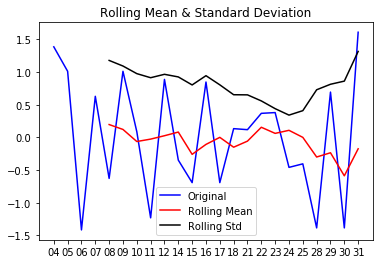

Results of Dickey-Fuller Test:
Test Statistic                 -2.721587
p-value                         0.070377
#Lags Used                      9.000000
Number of Observations Used    13.000000
Critical Value (1%)            -4.068854
Critical Value (5%)            -3.127149
Critical Value (10%)           -2.701730
dtype: float64


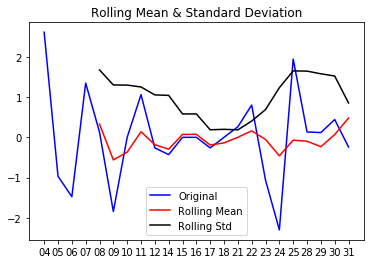

Results of Dickey-Fuller Test:
Test Statistic                -6.123402e+00
p-value                        8.744977e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.300000e+01
Critical Value (1%)           -4.068854e+00
Critical Value (5%)           -3.127149e+00
Critical Value (10%)          -2.701730e+00
dtype: float64


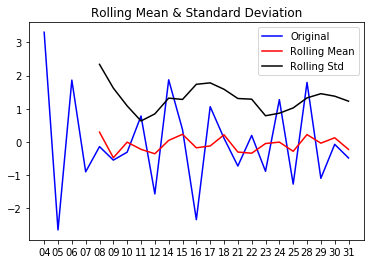

Results of Dickey-Fuller Test:
Test Statistic                 -3.087072
p-value                         0.027525
#Lags Used                      8.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64


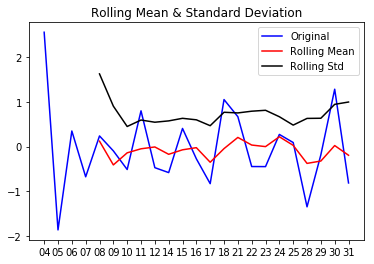

Results of Dickey-Fuller Test:
Test Statistic                 -5.622898
p-value                         0.000001
#Lags Used                      1.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


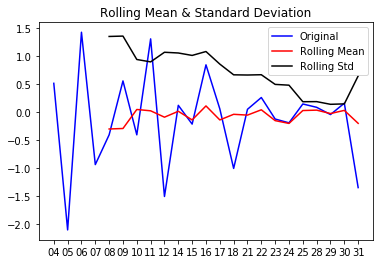

Results of Dickey-Fuller Test:
Test Statistic                 -2.448324
p-value                         0.128559
#Lags Used                      7.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
dtype: float64


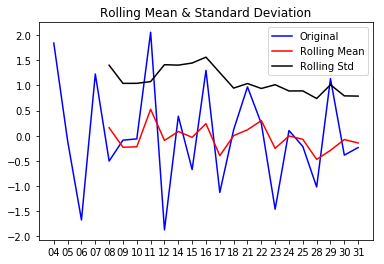

Results of Dickey-Fuller Test:
Test Statistic                -8.129899e+00
p-value                        1.097408e-12
#Lags Used                     0.000000e+00
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


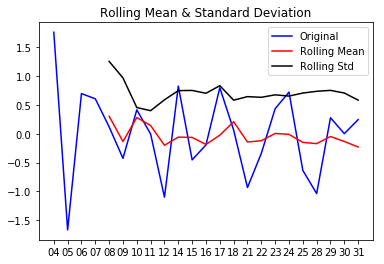

Results of Dickey-Fuller Test:
Test Statistic                 -3.195184
p-value                         0.020265
#Lags Used                      3.000000
Number of Observations Used    19.000000
Critical Value (1%)            -3.832603
Critical Value (5%)            -3.031227
Critical Value (10%)           -2.655520
dtype: float64


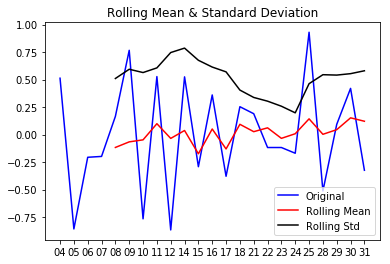

Results of Dickey-Fuller Test:
Test Statistic                 -3.944419
p-value                         0.001731
#Lags Used                      2.000000
Number of Observations Used    20.000000
Critical Value (1%)            -3.809209
Critical Value (5%)            -3.021645
Critical Value (10%)           -2.650713
dtype: float64


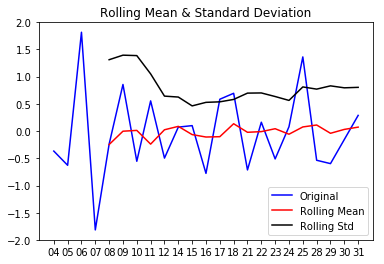

Results of Dickey-Fuller Test:
Test Statistic                  0.153913
p-value                         0.969555
#Lags Used                      9.000000
Number of Observations Used    13.000000
Critical Value (1%)            -4.068854
Critical Value (5%)            -3.127149
Critical Value (10%)           -2.701730
dtype: float64


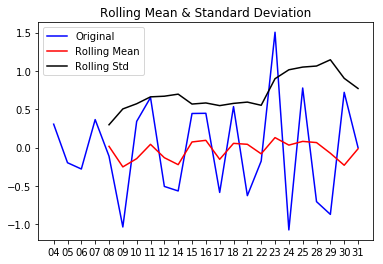

Results of Dickey-Fuller Test:
Test Statistic                -7.695348e+00
p-value                        1.384052e-11
#Lags Used                     9.000000e+00
Number of Observations Used    1.300000e+01
Critical Value (1%)           -4.068854e+00
Critical Value (5%)           -3.127149e+00
Critical Value (10%)          -2.701730e+00
dtype: float64


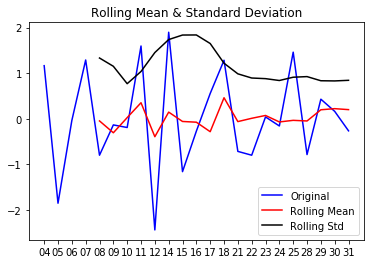

Results of Dickey-Fuller Test:
Test Statistic                 -1.257049
p-value                         0.648586
#Lags Used                      8.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64


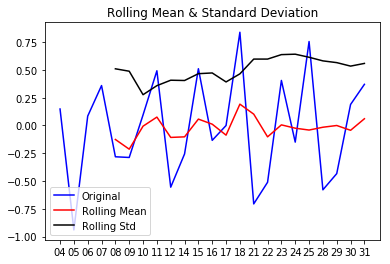

Results of Dickey-Fuller Test:
Test Statistic                 -3.095260
p-value                         0.026906
#Lags Used                      4.000000
Number of Observations Used    18.000000
Critical Value (1%)            -3.859073
Critical Value (5%)            -3.042046
Critical Value (10%)           -2.660906
dtype: float64


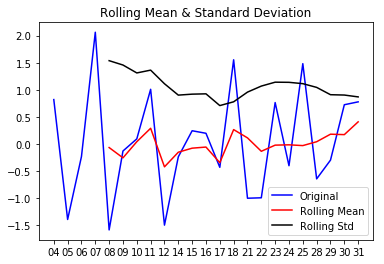

Results of Dickey-Fuller Test:
Test Statistic                -6.945409e+00
p-value                        1.000187e-09
#Lags Used                     0.000000e+00
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


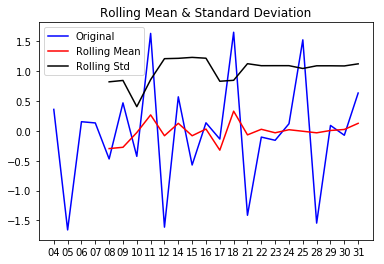

Results of Dickey-Fuller Test:
Test Statistic                -6.934130e+00
p-value                        1.065377e-09
#Lags Used                     9.000000e+00
Number of Observations Used    1.300000e+01
Critical Value (1%)           -4.068854e+00
Critical Value (5%)           -3.127149e+00
Critical Value (10%)          -2.701730e+00
dtype: float64


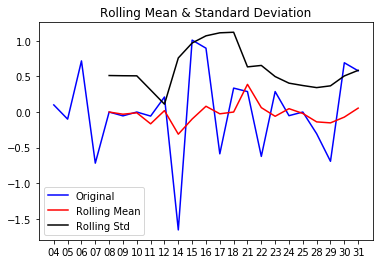

Results of Dickey-Fuller Test:
Test Statistic                -25.153240
p-value                         0.000000
#Lags Used                      9.000000
Number of Observations Used    13.000000
Critical Value (1%)            -4.068854
Critical Value (5%)            -3.127149
Critical Value (10%)           -2.701730
dtype: float64


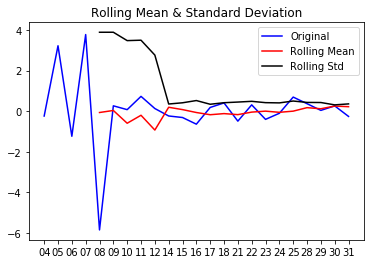

Results of Dickey-Fuller Test:
Test Statistic                 -0.128642
p-value                         0.946510
#Lags Used                      9.000000
Number of Observations Used    13.000000
Critical Value (1%)            -4.068854
Critical Value (5%)            -3.127149
Critical Value (10%)           -2.701730
dtype: float64


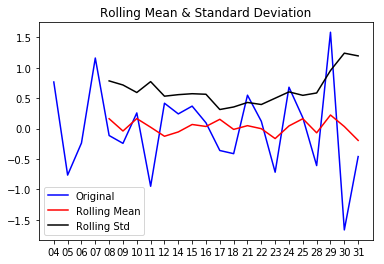

Results of Dickey-Fuller Test:
Test Statistic                 -1.794303
p-value                         0.383294
#Lags Used                      9.000000
Number of Observations Used    13.000000
Critical Value (1%)            -4.068854
Critical Value (5%)            -3.127149
Critical Value (10%)           -2.701730
dtype: float64


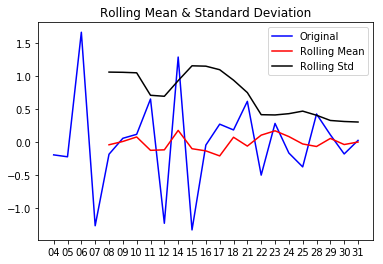

Results of Dickey-Fuller Test:
Test Statistic                -1.112415e+01
p-value                        3.407237e-20
#Lags Used                     9.000000e+00
Number of Observations Used    1.300000e+01
Critical Value (1%)           -4.068854e+00
Critical Value (5%)           -3.127149e+00
Critical Value (10%)          -2.701730e+00
dtype: float64


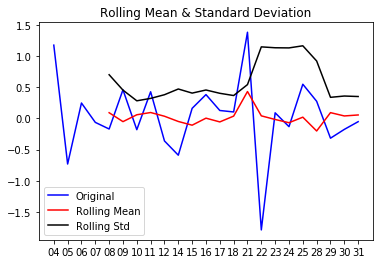

Results of Dickey-Fuller Test:
Test Statistic                -7.722754e+00
p-value                        1.180651e-11
#Lags Used                     0.000000e+00
Number of Observations Used    2.200000e+01
Critical Value (1%)           -3.769733e+00
Critical Value (5%)           -3.005426e+00
Critical Value (10%)          -2.642501e+00
dtype: float64


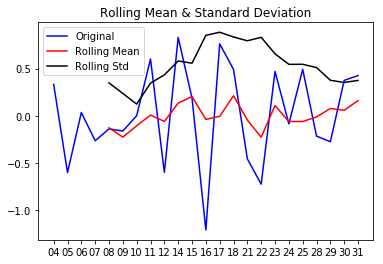

Results of Dickey-Fuller Test:
Test Statistic                -6.009063e+00
p-value                        1.589507e-07
#Lags Used                     1.000000e+00
Number of Observations Used    2.100000e+01
Critical Value (1%)           -3.788386e+00
Critical Value (5%)           -3.013098e+00
Critical Value (10%)          -2.646397e+00
dtype: float64


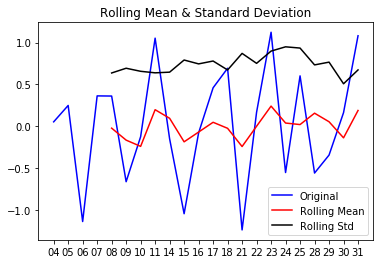

Results of Dickey-Fuller Test:
Test Statistic                 -4.798922
p-value                         0.000055
#Lags Used                      2.000000
Number of Observations Used    19.000000
Critical Value (1%)            -3.832603
Critical Value (5%)            -3.031227
Critical Value (10%)           -2.655520
dtype: float64


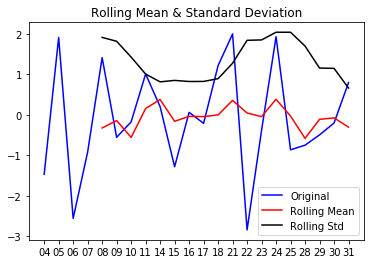

Results of Dickey-Fuller Test:
Test Statistic                 -0.169107
p-value                         0.942105
#Lags Used                      9.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


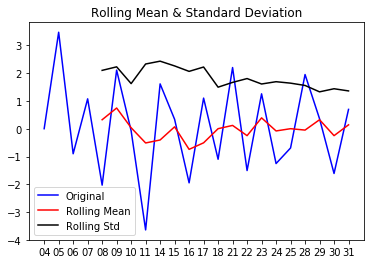

Results of Dickey-Fuller Test:
Test Statistic                 -5.622025
p-value                         0.000001
#Lags Used                      1.000000
Number of Observations Used    20.000000
Critical Value (1%)            -3.809209
Critical Value (5%)            -3.021645
Critical Value (10%)           -2.650713
dtype: float64


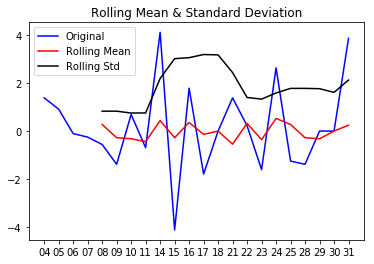

Results of Dickey-Fuller Test:
Test Statistic                 -0.249796
p-value                         0.932320
#Lags Used                      9.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


In [15]:
for i in range(0,len(hourly_loop_list)):
    globals()[hourly_loop_list[i]] = df_time_group.loc[(hourly_num_list[i],slice(None)),:]
#     globals()[hourly_loop_list[i]].index = globals()[hourly_loop_list[i]].index.droplevel()
#     globals()[hourly_loop_list[i]] = globals()[hourly_loop_list[i]].reset_index(drop = True)
    globals()[hourly_loop_list[i]] = globals()[hourly_loop_list[i]].reset_index()
    globals()[hourly_loop_list[i]].drop(['time'],axis = 1,inplace = True)
    globals()[hourly_loop_list[i]].set_index(['date'],inplace = True)
    globals()[hourly_loop_list[i]]['OngoingFailureNum'] = globals()[hourly_loop_list[i]]['OngoingFailureNum'].apply(lambda x : 0.99999 if x == 0 else x)
    hourly_log = np.log(globals()[hourly_loop_list[i]]['OngoingFailureNum'])
#     plt.plot(globals()[hourly_log_list[i]])

# # 1:移动平均数    
    moving_avg = hourly_log.rolling(20).mean()
    hourly_log_diff = hourly_log - moving_avg
    hourly_log_diff.dropna(inplace = True)

## 2:指数加权移动平均法  

#     expwighted_avg = pd.ewma(hourly_log, halflife=2)
#     hourly_log_ewma_diff = hourly_log - expwighted_avg

# 3:差分

    hourly_log_diff2 = hourly_log - hourly_log.shift()
    hourly_log_diff2.dropna(inplace=True)

## 4:分解  < =========== 版本不同不能用 seasonal_decompose 的包

#     from statsmodels.tsa.seasonal import seasonal_decompose

#     decomposition = seasonal_decompose(hourly_log)

#     trend = decomposition.trend
#     seasonal = decomposition.seasonal
#     residual = decomposition.resid

#     hourly_log_decompose = residual
#     hourly_log_decompose.dropna(inplace=True)

## 测试stationarity 稳定性！

    test_stationarity(hourly_log_diff2)

    
#     plt.plot(globals()[hourly_log_list[i]]['OngoingFailureNum'])
#     plt.plot(moving_avg, color='red')
    



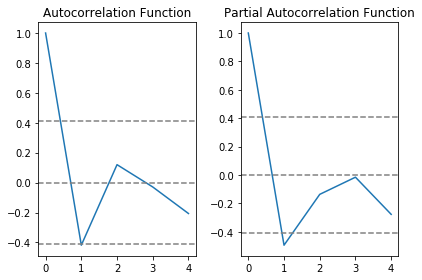

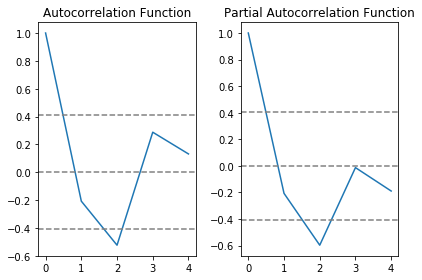

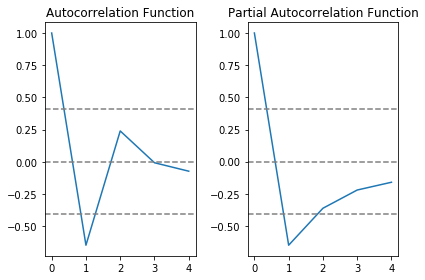

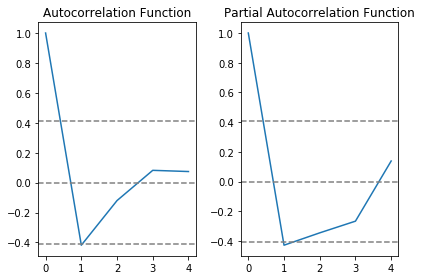

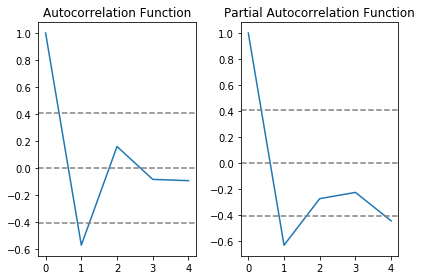

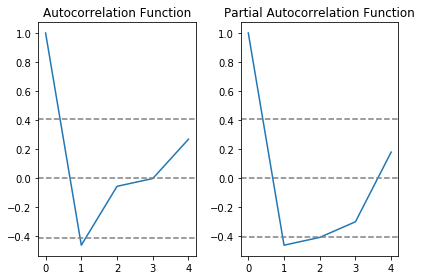

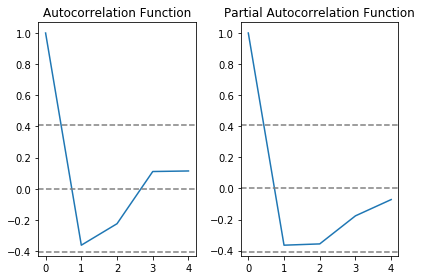

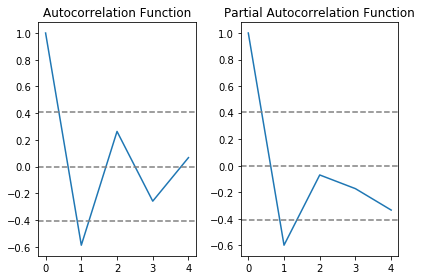

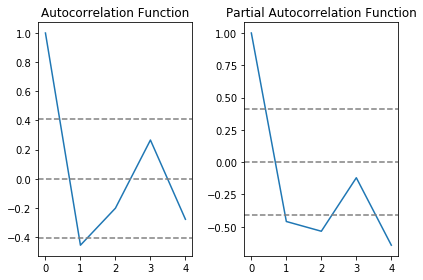

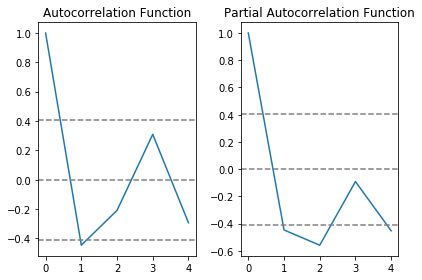

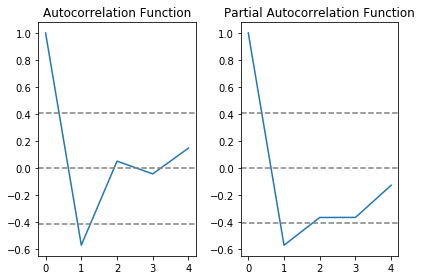

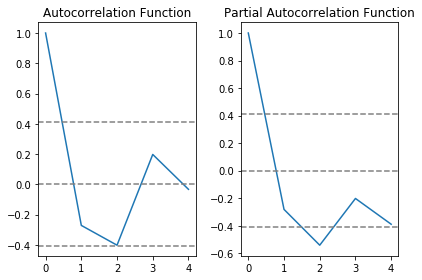

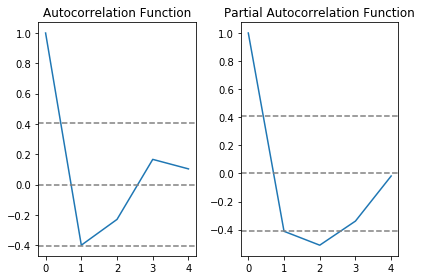

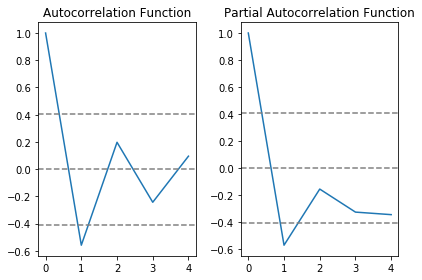

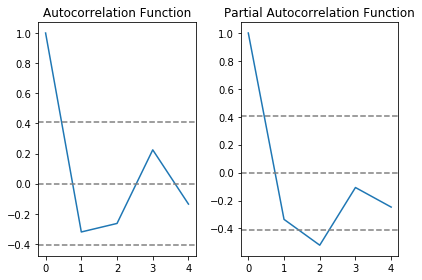

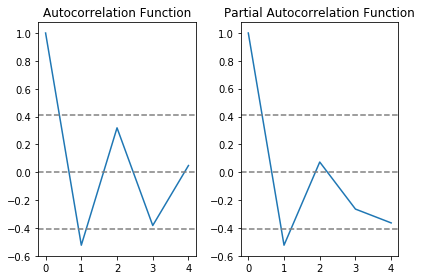

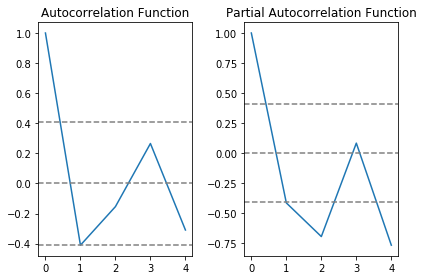

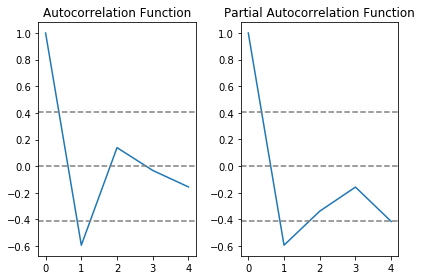

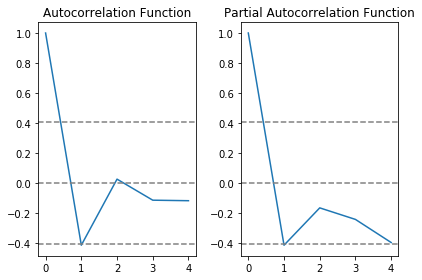

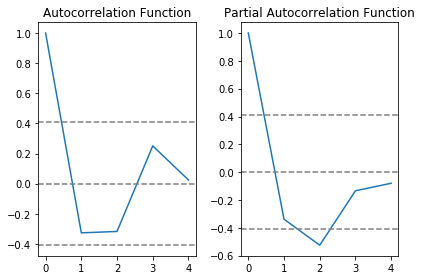

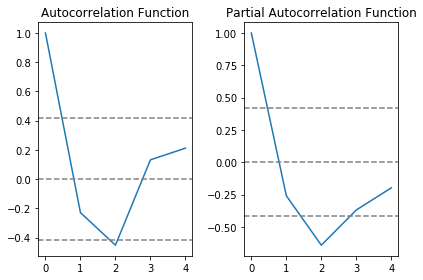

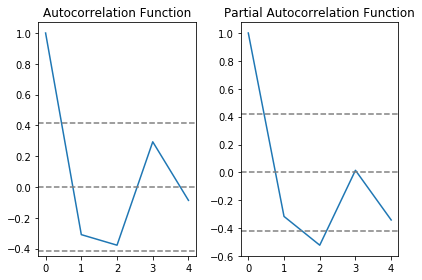

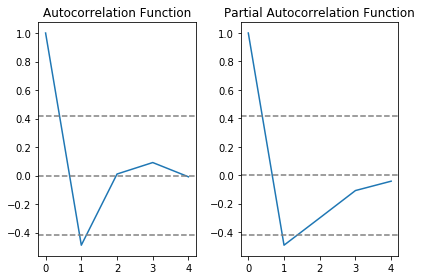

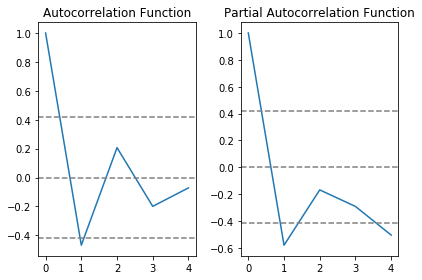

In [22]:
from statsmodels.tsa.stattools import acf, pacf

def plotk(hourly_log_diff):
    lag_acf = acf(hourly_log_diff, nlags=4)
    lag_pacf = pacf(hourly_log_diff, nlags=4, method='ols')
    #Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(hourly_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(hourly_log_diff)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(hourly_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(hourly_log_diff)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()
  
    plt.show(block=False)
    
#=========================================================================
          
# for i in range(0):
for i in range(0,len(hourly_loop_list)):
    globals()[hourly_loop_list[i]] = df_time_group.loc[(hourly_num_list[i],slice(None)),:]
    globals()[hourly_loop_list[i]] = globals()[hourly_loop_list[i]].reset_index()
    globals()[hourly_loop_list[i]].drop(['time'],axis = 1,inplace = True)
    globals()[hourly_loop_list[i]].set_index(['date'],inplace = True)
    globals()[hourly_loop_list[i]]['OngoingFailureNum'] = globals()[hourly_loop_list[i]]['OngoingFailureNum'].apply(lambda x : 0.99999 if x == 0 else x)
    hourly_log = np.log(globals()[hourly_loop_list[i]]['OngoingFailureNum'])
 
    moving_avg = hourly_log.rolling(5).mean()
    hourly_log_diff = hourly_log - moving_avg
    hourly_log_diff.dropna(inplace = True)
    
    hourly_log_diff2 = hourly_log - hourly_log.shift()
    hourly_log_diff2.dropna(inplace=True)

    plotk(hourly_log_diff2)




C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:55: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


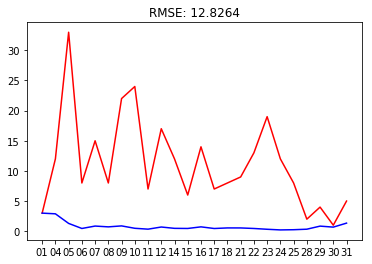

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


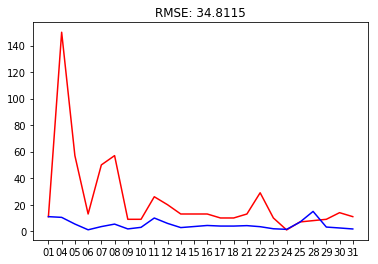

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


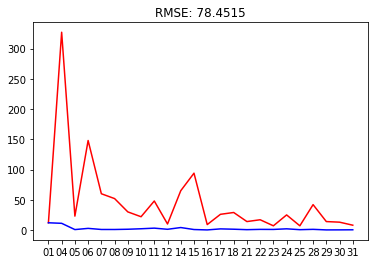

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


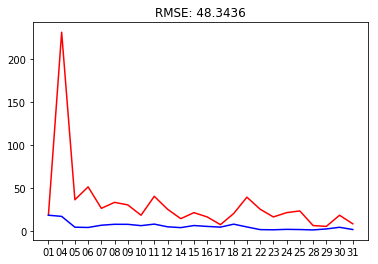

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


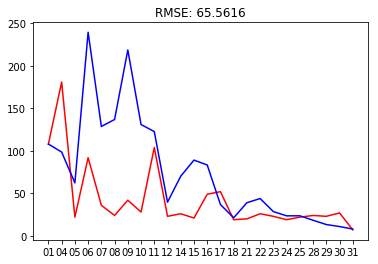

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


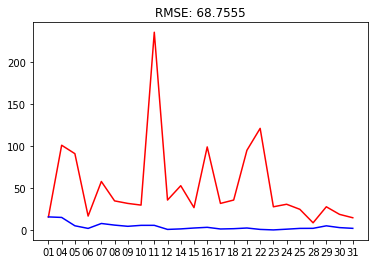

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


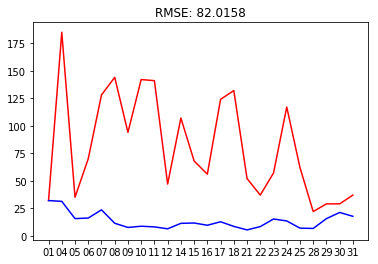

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


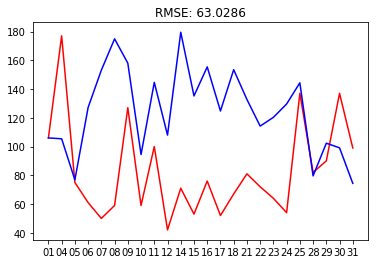

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


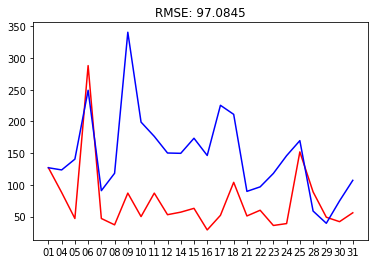

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


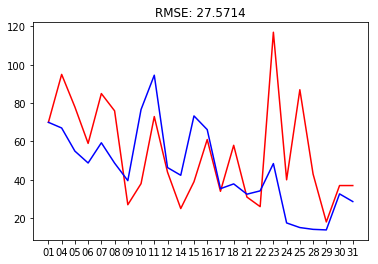

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


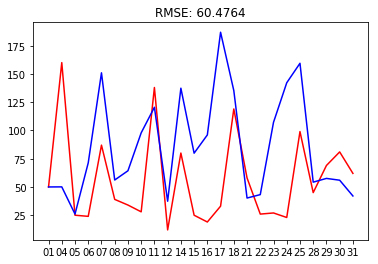

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


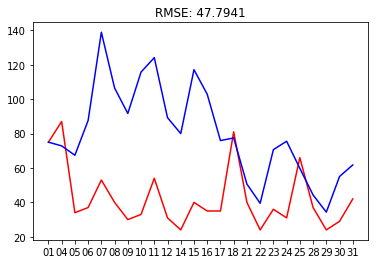

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


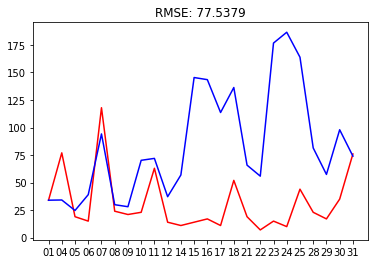

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


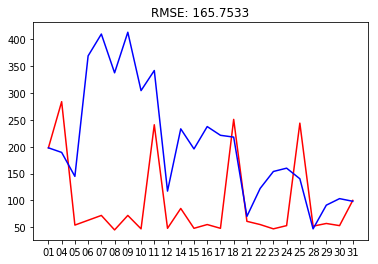

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


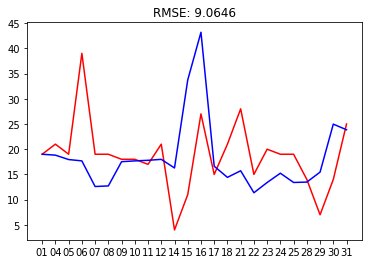

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


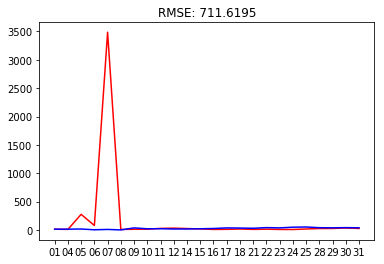

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


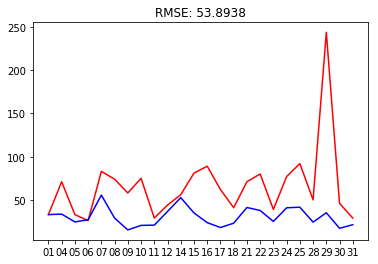

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


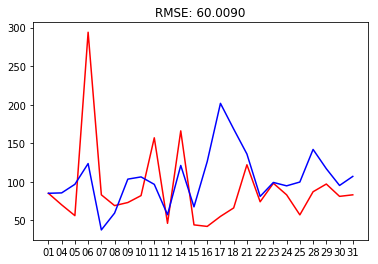

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


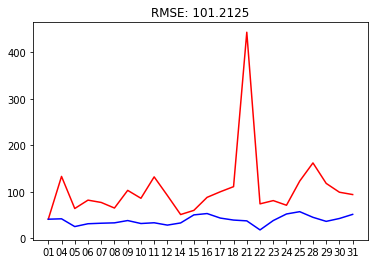

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


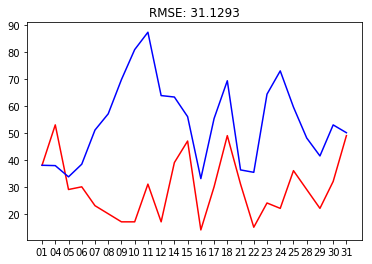

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


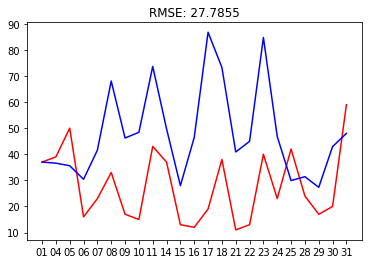

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


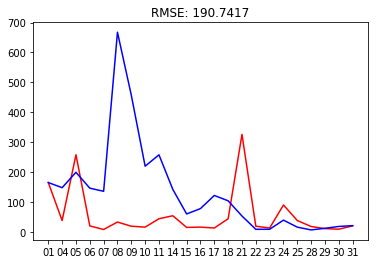

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


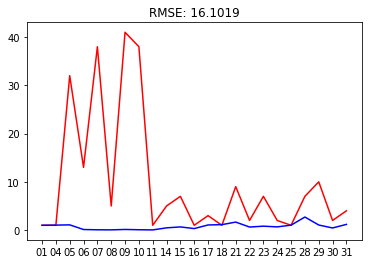

C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Mma4\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


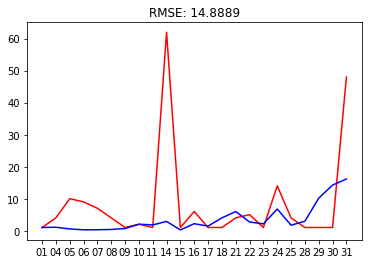

In [20]:
from statsmodels.tsa.arima_model import ARIMA

for i in range(0,len(hourly_loop_list)):
    globals()[hourly_loop_list[i]] = df_time_group.loc[(hourly_num_list[i],slice(None)),:]
    globals()[hourly_loop_list[i]] = globals()[hourly_loop_list[i]].reset_index()
    globals()[hourly_loop_list[i]].drop(['time'],axis = 1,inplace = True)
    globals()[hourly_loop_list[i]].set_index(['date'],inplace = True)
    globals()[hourly_loop_list[i]]['OngoingFailureNum'] = globals()[hourly_loop_list[i]]['OngoingFailureNum'].apply(lambda x : 0.99999 if x == 0 else x)
    hourly = globals()[hourly_loop_list[i]]['OngoingFailureNum']
    hourly_log = np.log(globals()[hourly_loop_list[i]]['OngoingFailureNum'])
 
    moving_avg = hourly_log.rolling(5).mean()
    hourly_log_diff = hourly_log - moving_avg
    hourly_log_diff.dropna(inplace = True)

    hourly_log_diff2 = hourly_log - hourly_log.shift()
    hourly_log_diff2.dropna(inplace=True)
    
#   ## 自回归（AR）模型：

    model = ARIMA(hourly_log, order=(2, 1, 0))  
    results_AR = model.fit(disp=-1)  
#     plt.plot(hourly_log_diff)
#     plt.plot(results_AR.fittedvalues, color='red')
#     plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-hourly_log_diff)**2))
#     plt.show(block=False)

#     ## 组合模型

#     model = ARIMA(hourly_log, order=(0, 1, 2))  
#     results_MA = model.fit(disp=-1)  
#     plt.plot(hourly_log_diff)
#     plt.plot(results_MA.fittedvalues, color='red')
#     plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-hourly_log_diff)**2))

#     ##移动平均数（MA ）模型

#     model = ARIMA(hourly_log, order=(2, 1, 2))  
#     results_ARIMA = model.fit(disp=-1)  
#     plt.plot(hourly_log_diff)
#     plt.plot(results_ARIMA.fittedvalues, color='red')
#     plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-hourly_log_diff)**2))

# ========================  ## 倒回到原始区间  =======================================

# predictions_ARIMA_diff    

    predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
    
# predictions_ARIMA_diff_cumsum
    
    predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

# predictions_ARIMA_log  

    predictions_ARIMA_log = pd.Series(hourly_log.ix[0], index=hourly_log.index)
    predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

    
# predictions_ARIMA_log  
    
    predictions_ARIMA = np.exp(predictions_ARIMA_log)
    plt.plot(hourly,color='red')
    plt.plot(predictions_ARIMA,color='blue')
    plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-hourly)**2)/len(hourly)))

    plt.show(block=False)